In [1]:
import numpy as np
import pandas as pd

In [124]:
import matplotlib.pyplot as plt

import scipy.stats as stats
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, mean_squared_error

import seaborn as sns

# FUNCTIONS

In [3]:
def single_temp(air_temp, critical_temp):

    type_list = list()
    for i in range(air_temp.shape[0]):
        if air_temp[i] < critical_temp:
            # SNOW
            type_list.append(1)
        elif air_temp[i] >= critical_temp:
            # RAIN
            type_list.append(0)
            
    return type_list

# LOADING DATA
- Data is loaded from two different files:
    - `data_svv` contains data from Statens Vegvesen (vegvesen.no/vegvar)
    - `data_frost` contains data from Norwegian Meteorological Institute (frost.met.no)
- Precipitation type is contained in `data_svv` and is converted to binary codes:
    - 0: rain
    - 1: snow
- Only the measurements of precipitation is chosen. This drastically reduces the number of samples.
- NaN values are removed from both datasets (which again reduces the number of samples)
- After this, the data sets are split into traning and test sets
- Standardizing (?) is applied (?)

In [4]:
#data = pd.read_csv('met_data.csv')

data_svv = pd.read_excel('Eksport-Fv-37-Jonjiljo-2019-10-01_ny.xlsx')
#data_svv['Tidspunkt'] = pd.to_datetime(data_svv['Tidspunkt'])
data_frost = pd.read_csv('SN31700_nyere.csv')

In [5]:
# CONVERT SVV PRECIPITATION TYPE DESCRIPTION TO NUMERIC VALUES
data_svv.loc[data_svv['Nedbørstype'] == 'Opphold', 'Nedbørstype'] = 9999
data_svv.loc[data_svv['Nedbørstype'] == 'Sno', 'Nedbørstype'] = 1
data_svv.loc[data_svv['Nedbørstype'] == 'Regn', 'Nedbørstype'] = 0
data_svv.loc[data_svv['Nedbørstype'] == 'Yr', 'Nedbørstype'] = 0
data_svv.loc[data_svv['Nedbørstype'] == 'Uspesifisert', 'Nedbørstype'] = 9999

In [6]:
# Choose dates with precipitation
prec_type = data_svv.loc[data_svv['Nedbørstype'] != 9999]['Nedbørstype'] # precipitation type when precipitation
Ta = data_frost['air_temperature'][prec_type.index].reset_index()
rel_hum = data_frost['relative_humidity'][prec_type.index].reset_index()
prec_type = prec_type.reset_index()
Td = data_frost['dew_point_temperature'][prec_type.index].reset_index()
wind_speed = data_frost['wind_speed'][prec_type.index].reset_index()

In [7]:
# CREATE FEATURE AND TARGET DATA
X_final = pd.DataFrame()
X_final['air_temperature'] = Ta['air_temperature']
X_final['relative_humidity'] = rel_hum['relative_humidity']
X_final['dew_point_temperature'] = Td['dew_point_temperature']
X_final['wind_speed'] = wind_speed['wind_speed']
y_final = pd.DataFrame()
y_final['type'] = prec_type['Nedbørstype']

In [8]:
# Removing nan values from X and the corresponding entries in y
nan_idx = pd.isnull(X_final).any(1).nonzero()[0]
nan_idx_y = pd.isnull(y_final).any(1).nonzero()[0]

X_final = X_final.dropna()
y_final = y_final.dropna()
for idx in nan_idx_y:
    if idx in list(X_final.index):
        X_final = X_final.drop(idx)
        
for idx in nan_idx:
    if idx in list(y_final.index):
        y_final = y_final.drop(idx)

In [9]:
# Removing nan values from y and the corresponding entries in X
nan_idx_y = pd.isnull(y_final).any(1).nonzero()[0]
y_final = y_final.dropna()

#X_final = X_final.drop(nan_idx_y)

for idx in nan_idx_y:
    if idx in list(X_final.index):
        X_final = X_final.drop(idx)

In [10]:
# Create traning and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, random_state=42, test_size=0.3)

In [ ]:
# Preprocessing
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [11]:
# CHANGE y_train AND y_test TO LISTS
# Had to do this because sklearn did not like the format all of a sudden, do not know why

y_train_list = list(y_train['type'])
y_test_list = list(y_test['type'])

# MODELS
- The three different models are applied

### Single temperature threshold
- `Tc_opt` is the critical temperature threshold found during training
- Training for this method corresponds to calibration of a hydrological model. During calibration, all parameters, including the critical temperature threshold, is found.

In [145]:
# Single temperature threshold
Tc_list = np.arange(-2, 8, 0.1)
F1_sc = list()
accuracy = list()
MSE = list()
for Tc in Tc_list:
    pred_single_temp = single_temp(X_train['air_temperature'].reset_index(drop=True), Tc)
    
    F1_sc.append(f1_score(y_train_list, pred_single_temp))
    accuracy.append(accuracy_score(y_train_list, pred_single_temp))
    MSE.append(mean_squared_error(y_train_list, pred_single_temp))
    
Tc_opt = Tc_list[np.argmax(F1_sc)]
Tc_opt_acc = Tc_list[np.argmax(accuracy)]
Tc_opt_MSE = Tc_list[np.argmin(MSE)]
print(Tc_opt)
#print(Tc_opt_acc)
#print(Tc_opt_MSE)
pred_single_temp_test = single_temp(X_test['air_temperature'].reset_index(drop=True), Tc_opt)

1.8000000000000034
0.40000000000000213
0.40000000000000213


### Logistic regression
- We want to run for a range of C values to find the one that gives the highest F1 score

In [233]:
C_vals = np.arange(0.0001,0.1,0.001)

In [219]:
clf = linear_model.LogisticRegression(solver='lbfgs', C=0.0091)
clf.fit(X_train, y_train_list)
pred = clf.predict(X_test)

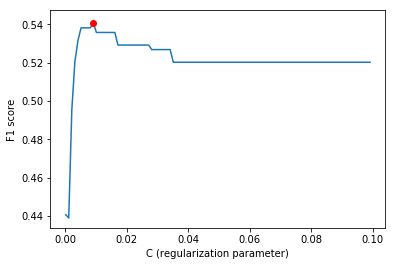

Optimal C value: 0.0091


In [241]:
F1_scl = list()
for c_val in C_vals:    
    
    # Logistic regression 
    clf = linear_model.LogisticRegression(solver='lbfgs', C=c_val)
    clf.fit(X_train, y_train_list)
    pred = clf.predict(X_test)

    # Logistic regression
    #print(confusion_matrix(y_test_list, pred))
    #print('C=', c_val, '\n')
    #print('F1', f1_score(y_test_list, pred))
    #print('MSE', mean_squared_error(y_test_list, pred))
    #print('Accuracy', accuracy_score(y_test_list, pred), '\n')
    F1_scl.append(f1_score(y_test_list, pred))
    #print(F1_scl)
    

plt.plot(C_vals, F1_scl, zorder=1)
plt.scatter(C_vals[np.argmax(F1_scl)], np.max(F1_scl), zorder=2, color='red')
plt.xlabel('C (regularization parameter)')
plt.ylabel('F1 score')
plt.show()

print('Optimal C value:', C_vals[np.argmax(F1_scl)])

### SVM

In [231]:
# Support Vector Machines
clf_svm = svm.SVC(gamma='auto')
clf_svm.fit(X_train, y_train_list)
pred_svm = clf_svm.predict(X_test)

# Evaluation metrics
- Different evaluation metrics are calculated for the three different methods

### Single temperature threshold

In [146]:
# Single temperature threshold
print(confusion_matrix(y_test_list, pred_single_temp_test))
print(f1_score(y_test_list, pred_single_temp_test))
print(mean_squared_error(y_test_list, pred_single_temp_test))
print(accuracy_score(y_test_list, pred_single_temp_test))

[[ 61 133]
 [  3 121]]
0.6402116402116402
0.4276729559748428
0.5723270440251572


### Logistic regression

In [221]:
# Logistic regression
print(confusion_matrix(y_test_list, pred))
print(f1_score(y_test_list, pred))
print(mean_squared_error(y_test_list, pred))
print(accuracy_score(y_test_list, pred))

[[156  38]
 [ 64  60]]
0.5405405405405406
0.32075471698113206
0.6792452830188679


### SVM

In [232]:
# Support Vector Machines
print(confusion_matrix(y_test_list, pred_svm))
print(f1_score(y_test_list, pred_svm))
print(mean_squared_error(y_test_list, pred_svm))
print(accuracy_score(y_test_list, pred_svm))

[[158  36]
 [ 16 108]]
0.8059701492537312
0.16352201257861634
0.8364779874213837


# PLOTS

In [114]:
Tc_list[list(Tc_list).index(Tc_list[np.argmax(F1_sc)])]

1.8000000000000034

### Want to run again to get both test and training data in plot below

In [127]:
# Single temperature threshold
Tc_list_test = np.arange(-2, 8, 0.1)
F1_sc_test = list()
accuracy_test = list()
MSE_test = list()
for Tc_test in Tc_list_test:
    pred_single_temp_test = single_temp(X_test['air_temperature'].reset_index(drop=True), Tc_test)
    
    F1_sc_test.append(f1_score(y_test_list, pred_single_temp_test))
    accuracy_test.append(accuracy_score(y_test_list, pred_single_temp_test))
    MSE_test.append(mean_squared_error(y_test_list, pred_single_temp_test))
    
Tc_opt_test = Tc_list_test[np.argmax(F1_sc_test)]
Tc_opt_acc = Tc_list_test[np.argmax(accuracy_test)]
Tc_opt_MSE = Tc_list_test[np.argmin(MSE_test)]
print(Tc_opt_test)
print(Tc_opt_acc)
print(Tc_opt_MSE)

1.9000000000000035
0.6000000000000023
0.6000000000000023


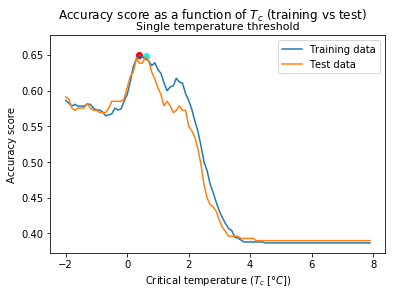

In [120]:
%matplotlib inline
plt.scatter(Tc_list[list(Tc_list).index(Tc_list[np.argmax(accuracy)])], np.max(accuracy), color = 'red', zorder=2)
plt.plot(Tc_list, accuracy, label='Training data')

plt.scatter(Tc_list_test[list(Tc_list_test).index(Tc_list_test[np.argmax(accuracy_test)])], np.max(accuracy_test), color = 'cyan', zorder=2)
plt.plot(Tc_list_test, accuracy_test, label='Test data')

plt.suptitle('Accuracy score as a function of $T_{c}$ (training vs test)', fontsize=12)
plt.title('Single temperature threshold', fontsize=11)
plt.xlabel('Critical temperature ($T_{c}$ [$\degree C$])')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

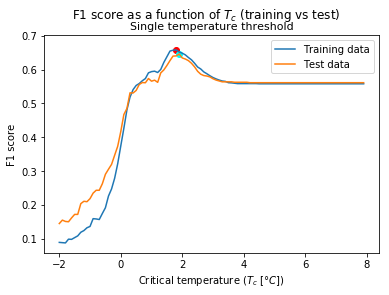

In [117]:
%matplotlib inline
plt.scatter(Tc_list[list(Tc_list).index(Tc_list[np.argmax(F1_sc)])], np.max(F1_sc), color = 'red', zorder=2)
plt.plot(Tc_list, F1_sc, label='Training data')

plt.scatter(Tc_list_test[list(Tc_list_test).index(Tc_list_test[np.argmax(F1_sc_test)])], np.max(F1_sc_test), color = 'cyan', zorder=2)
plt.plot(Tc_list_test, F1_sc_test, label='Test data')

plt.suptitle('F1 score as a function of $T_{c}$ (training vs test)', fontsize=12)
plt.title('Single temperature threshold', fontsize=11)
plt.xlabel('Critical temperature ($T_{c}$ [$\degree C$])')
plt.ylabel('F1 score')
plt.legend()
plt.show()

In [ ]:
%matplotlib inline
plt.scatter(Tc_list_test[list(Tc_list_test).index(Tc_list_test[np.argmax(F1_sc_test)])], np.max(F1_sc_test), color = 'red', zorder=2)
plt.plot(Tc_list_test, F1_sc_test, zorder=1)
plt.suptitle('F1 score as a function of $T_{c}$ (test data)', fontsize=12)
plt.title('Single temperature threshold', fontsize=11)
plt.xlabel('Critical temperature ($T_{c}$ [$\degree C$])')
plt.ylabel('F1 score')
plt.show()

In [173]:
time_range = data_frost['referenceTime']
dates = time_range[X_final.index]
dates = ['2019-10-01', '2019-10-10', '2019-10-17', '2019-10-24', '2019-11-31', '2019-11-07', '2019-11-14', '2019-11-21', '2019-11-28'] 

date_range = np.arange(0, data_frost.shape[0], (int(data_frost.shape[0]/len(dates))))

date_list = list()
for i in range(0,len(dates),int(len(dates)/8)):
    #date_list.append(dates.reset_index(drop=True)[i])#[0:10])
    date_list.append(dates[i])

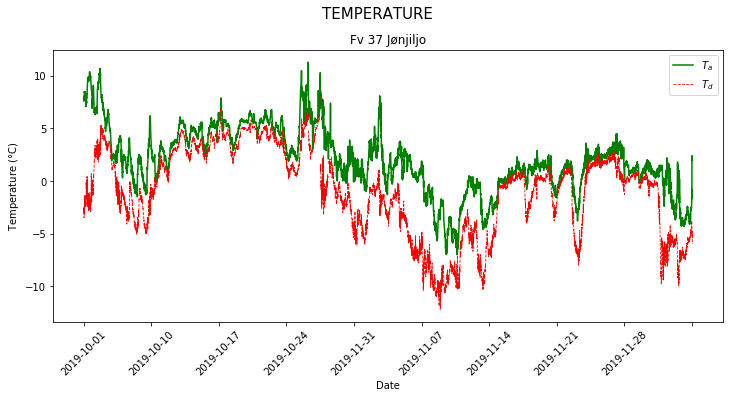

In [171]:
plt.figure(figsize=(12,5))
plt.plot(data_frost['air_temperature'], color='green', label='$T_{a}$')
plt.plot(data_frost['dew_point_temperature'], color='red', linestyle='--', label='$T_{d}$', linewidth=0.8)
#plt.xticks(date_range,)
plt.xticks(date_range, date_list, rotation='45')
plt.suptitle('TEMPERATURE\n',y=1, fontsize=15)
plt.xlabel('Date')
plt.ylabel('Temperature ($\degree$C)')
plt.title('Fv 37 Jønjiljo')
plt.legend()
plt.show()

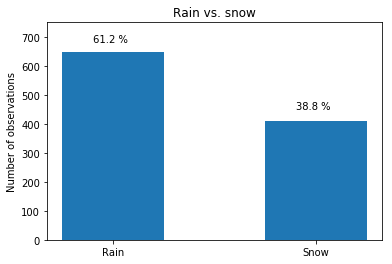

In [94]:
plt.hist(list(y_final.type), bins = 2, rwidth=0.5)
plt.xticks([0.25, 0.75], ['Rain', 'Snow'])
plt.ylim(0,750)
plt.ylabel('Number of observations')
plt.title('Rain vs. snow')
snow_p = np.count_nonzero(list(y_final.type))/len(list(y_final.type))
rain_p = 1 - snow_p
plt.text(0.2, 680, str(np.round(rain_p*100,1))+' %')
plt.text(0.7, 450, str(np.round(snow_p*100,1))+' %')
plt.show()

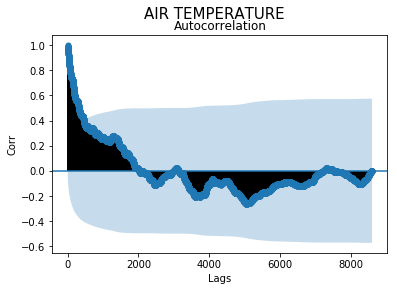

In [22]:
plot_acf(data_frost['air_temperature'])
plt.suptitle('AIR TEMPERATURE', fontsize=15)
plt.title('Autocorrelation',fontsize=12)
plt.xlabel('Lags')
plt.ylabel('Corr')
plt.show()

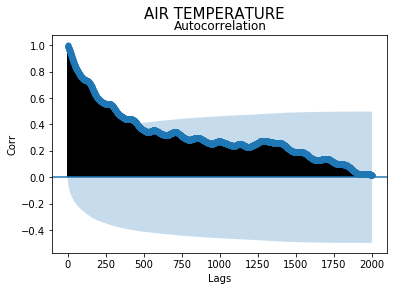

In [24]:
plot_acf(data_frost['air_temperature'], lags=2000)
plt.suptitle('AIR TEMPERATURE', fontsize=15)
plt.title('Autocorrelation',fontsize=12)
plt.xlabel('Lags')
plt.ylabel('Corr')
plt.show()

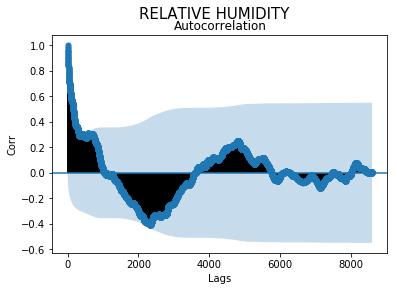

In [77]:
plot_acf(data_frost['relative_humidity'])#, lags=200)
plt.suptitle('RELATIVE HUMIDITY', fontsize=15)
plt.title('Autocorrelation',fontsize=12)
plt.xlabel('Lags')
plt.ylabel('Corr')
plt.show()

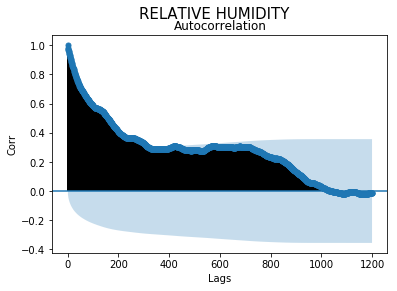

In [76]:
plot_acf(data_frost['relative_humidity'], lags=1200)
plt.suptitle('RELATIVE HUMIDITY', fontsize=15)
plt.title('Autocorrelation',fontsize=12)
plt.xlabel('Lags')
plt.ylabel('Corr')
plt.show()

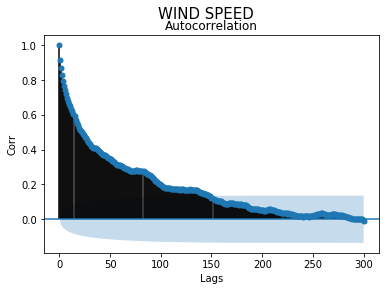

In [93]:
plot_acf(data_frost['wind_speed'], lags=300)
plt.suptitle('WIND SPEED', fontsize=15)
plt.title('Autocorrelation',fontsize=12)
plt.xlabel('Lags')
plt.ylabel('Corr')
plt.show()

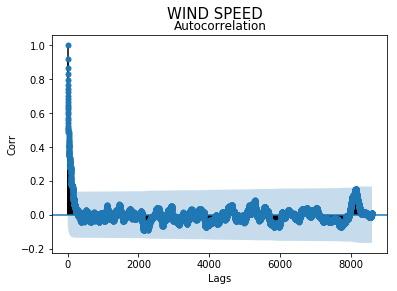

In [92]:
plot_acf(data_frost['wind_speed'])#, lags=200)
plt.suptitle('WIND SPEED', fontsize=15)
plt.title('Autocorrelation',fontsize=12)
plt.xlabel('Lags')
plt.ylabel('Corr')
plt.show()

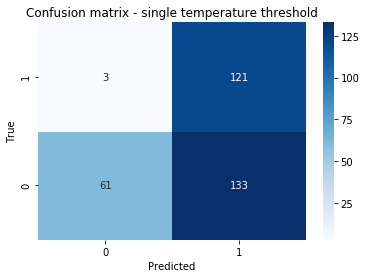

In [242]:
ax = sns.heatmap(confusion_matrix(y_test_list, pred_single_temp_test), annot=True, fmt='g', cmap='Blues')
ax.invert_yaxis()
plt.title('Confusion matrix - single temperature threshold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

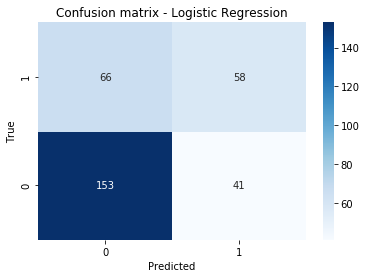

In [243]:
ax = sns.heatmap(confusion_matrix(y_test_list, pred), annot=True, fmt='g', cmap='Blues')
ax.invert_yaxis()
plt.title('Confusion matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

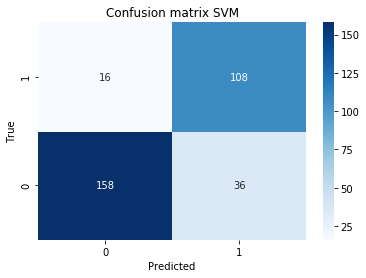

In [244]:
ax = sns.heatmap(confusion_matrix(y_test_list, pred_svm), annot=True, fmt='g', cmap='Blues')
ax.invert_yaxis()
plt.title('Confusion matrix SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()